# Generalized Linear Model

In [1]:
from pearl.bayesnet import from_yaml
from pearl.data import VariableData, BayesianNetworkDataset
from pearl.common import NodeValueType

import torch

import matplotlib.pyplot as plt

from pyro.optim import Adam

import graphviz

In this notebook we define and train a simple generalized linea model. Let us consider a model with 5 variables. The dependent variable 'E' has discrete parents 'A', 'B' and continuous parents 'C', 'D'. For each combination of discrete parents, 'E' is sampled from a categorical distribution (with 2 categories) obtained by applying a softmax function to linear combinations of the continuous parents 'C', 'D'. The exact data generating mechanism is shown below.

In [2]:
N = 5000

# 'A' and 'B' are sampled from categorical distributions
# 'C' and 'D' are sampled from Normal distributions
a = torch.distributions.Categorical(torch.tensor([0.3, 0.7])).sample((N,)).float()
b = torch.distributions.Categorical(torch.tensor([0.6, 0.4])).sample((N,)).float()
c = torch.distributions.Normal(0., 1.).sample((N,)).float()
d = torch.distributions.Normal(3, 1.).sample((N,)).float()

parents_stack = torch.stack([c,d], dim=-1).unsqueeze(-1).expand(-1, -1, 2)

mask1 = torch.eq(a, 0.) & torch.eq(b, 0.)
mask2 = torch.eq(a, 0.) & torch.eq(b, 1.)
mask3 = torch.eq(a, 1.) & torch.eq(b, 0.)
mask4 = torch.eq(a, 1.) & torch.eq(b, 1.)

# 'E' is sampled using a generalized linear model.
# For each combination of values of 'A' and 'B', we use a softmax function applied to two linear functions of 'C' and 'D' to generate a categorical distribution.
# 'E' is finally sampled from this categorical distribution.
e = torch.empty((N,))
bias = torch.tensor([
    [
        [
            [0.0, 0.0]
        ],
        [
            [0.0, 0.0]
        ]
    ],
    [
        [
            [0.0, 0.0]
        ],
        [
            [0.0, 0.0]
        ]
    ],
])
weights = torch.tensor(
    [
        [
            [
                [1.0, 1.25],
                [1.0, 1.50],
            ],
            [
                [1.0, 1.75],
                [1.0, 2.00],
            ],
        ],
        [
            [
                [2.00, 1.0],
                [1.75, 1.0],
            ],
            [
                [1.50, 1.0],
                [1.25, 1.0],
            ]
        ],
    ],
)

e[mask1] = torch.distributions.Categorical(
    torch.softmax(
        torch.sum(parents_stack * weights[0][0], dim=-2) + bias[0][0], 
        dim=-1
    )
).sample().float()[mask1]
e[mask2] = torch.distributions.Categorical(
    torch.softmax(
        torch.sum(parents_stack * weights[0][1], dim=-2) + bias[0][1], 
        dim=-1
    )
).sample().float()[mask2]
e[mask3] = torch.distributions.Categorical(
    torch.softmax(
        torch.sum(parents_stack * weights[1][0], dim=-2) + bias[1][0], 
        dim=-1
    )
).sample().float()[mask3]
e[mask4] = torch.distributions.Categorical(
    torch.softmax(
        torch.sum(parents_stack * weights[1][1], dim=-2) + bias[1][1], 
        dim=-1
    )
).sample().float()[mask4]

In [3]:
assert a.shape == b.shape == c.shape == d.shape == e.shape == (N,)

## Declarative model specification

The declarative specification the model and the graph structure are shown below.

In [4]:
! cat glmodel.yaml

device:
  index: 0
  type: cpu
encodingVersion: v1.0
name: glmodel
plates: {}
nodes:
  A:
    type: CategoricalNodeWithDirichletPrior
    domain: ['a', 'b']
    parents: []
    plates: []
  B:
    type: CategoricalNodeWithDirichletPrior
    domain: ['a', 'b']
    parents: []
    plates: []
  C:
    type: ContinuousNodeWithNormalDistribution
    parents: []
    plates: []
  D:
    type: ContinuousNodeWithNormalDistribution
    parents: []
    plates: []
  E:
    type: GeneralizedLinearNode
    domain: ['a', 'b']
    parents: ['A', 'B', 'C', 'D']
    plates: []


In [5]:
model = from_yaml('glmodel.yaml')
model.write_dot('glmodel.dot')

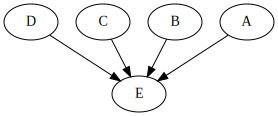

In [6]:
graphviz.Source.from_file('glmodel.dot')

## Model training

We will now train the model defined using pearl on the generated data and see how well it recovers the parameters of the generalized linear model. First we need to package the tensors as a `BayesianNetworkDataset` and divide it into train/test split.

In [7]:
variable_dict = {
    'A': VariableData(
        NodeValueType.CATEGORICAL,
        a,
        ['a', 'b'],
    ),
    'B': VariableData(
        NodeValueType.CATEGORICAL,
        b,
        ['a', 'b'],
    ),
    'C': VariableData(
        NodeValueType.CONTINUOUS,
        c,
    ),
    'D': VariableData(
        NodeValueType.CONTINUOUS,
        d,
    ),
    'E': VariableData(
        NodeValueType.CATEGORICAL,
        e,
        ['a', 'b'],
    )
}
dataset = BayesianNetworkDataset(variable_dict)

In [8]:
train_dataset, test_dataset = dataset.split((4000, 1000))

Next we will train the model using SVI to optimize the parameters.

In [9]:
adam = Adam({'lr': 0.005, 'betas': (0.95, 0.995)})

In [10]:
losses=model.train(
    dataset=train_dataset,
    optimizer=adam,
    num_steps=10000,
)

 10%|▉         | 997/10000 [00:14<02:12, 67.89it/s]svi_step: 1000
elbo: 18502.301599681377
 20%|█▉        | 1999/10000 [00:29<01:57, 68.36it/s]svi_step: 2000
elbo: 18481.76528418064
 30%|██▉       | 2996/10000 [00:44<01:40, 69.37it/s]svi_step: 3000
elbo: 18248.345020353794
 40%|███▉      | 3999/10000 [00:58<01:36, 62.00it/s]svi_step: 4000
elbo: 18257.90289145708
 50%|████▉     | 4998/10000 [01:13<01:13, 68.49it/s]svi_step: 5000
elbo: 18284.167265236378
 60%|█████▉    | 5998/10000 [01:28<00:59, 67.00it/s]svi_step: 6000
elbo: 18270.44609349966
 70%|██████▉   | 6994/10000 [01:42<00:43, 69.36it/s]svi_step: 7000
elbo: 18235.830620646477
 80%|███████▉  | 7997/10000 [01:57<00:29, 68.75it/s]svi_step: 8000
elbo: 18241.27462619543
 90%|████████▉ | 8992/10000 [02:11<00:14, 69.53it/s]svi_step: 9000
elbo: 18224.82104128599
100%|█████████▉| 9994/10000 [02:26<00:00, 69.68it/s]svi_step: 10000
elbo: 18239.26932001114
100%|██████████| 10000/10000 [02:26<00:00, 68.31it/s]
training time: 146.4099061489105

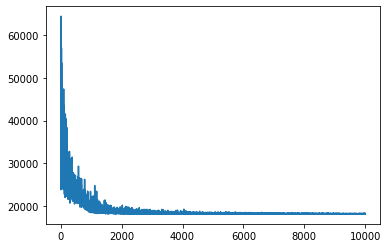

In [11]:
plt.plot(losses)

## Examine parameters

In [12]:
# CPD over A is Cat(0.3, 0.7 )
alphas = model.get_node_object('A').guide_alpha
print(alphas / torch.sum(alphas, dim=-1, keepdim=True))

tensor([0.2872, 0.7128], grad_fn=<DivBackward0>)


In [13]:
# CPD over B is Cat(0.6, 0.4 )
alphas = model.get_node_object('B').guide_alpha
print(alphas / torch.sum(alphas, dim=-1, keepdim=True))

tensor([0.5991, 0.4009], grad_fn=<DivBackward0>)


In [14]:
# CPD over C is N(0., 1.)
node_object = model.get_node_object('C')
mean = node_object.guide_mean_mean
scale = node_object.guide_scale
print(mean)
print(scale)

tensor(0.0073, requires_grad=True)
tensor(1.0071, grad_fn=<AddBackward0>)


In [15]:
# CPD over C is N(3., 1.)
node_object = model.get_node_object('D')
mean = node_object.guide_mean_mean
scale = node_object.guide_scale
print(mean)
print(scale)

tensor(3.0096, requires_grad=True)
tensor(0.9974, grad_fn=<AddBackward0>)


In [16]:
# CPD over E
node_object = model.get_node_object('E')
node_weights = node_object.guide_weights_mean
node_bias = node_object.guide_bias_mean
print(node_bias)
print(node_weights)

tensor([[[-0.1524,  0.1524],
         [ 0.4244, -0.4244]],

        [[ 0.1649, -0.1648],
         [ 0.0865, -0.0865]]], requires_grad=True)
tensor([[[[-0.1215,  0.1215],
          [-0.2178,  0.2178]],

         [[-0.4403,  0.4403],
          [-0.7369,  0.7369]]],


        [[[ 0.5110, -0.5110],
          [ 0.3410, -0.3410]],

         [[ 0.2721, -0.2721],
          [ 0.1013, -0.1013]]]], requires_grad=True)


The bias vector is close to zero since we did not use any bias term in the data generating mechanism for 'E'. While the exact weights may not be identical, its important that they induce the same categorical distribution through the softmax function. We verify that by computing the softmax of the two weight tensors.

In [17]:
print(torch.softmax(torch.sum(weights, dim=-2), dim=-1))
print(torch.softmax(torch.sum(node_weights, dim=-2) + node_bias, dim=-1))

tensor([[[0.3208, 0.6792],
         [0.1480, 0.8520]],

        [[0.8520, 0.1480],
         [0.6792, 0.3208]]])
tensor([[[0.2722, 0.7278],
         [0.1816, 0.8184]],

        [[0.8843, 0.1157],
         [0.7150, 0.2850]]], grad_fn=<SoftmaxBackward>)


## Predictions

We can use the trained model to answer various probabilistic queries. The standard query is to predict 'E' conditioned on the remaining variables.

In [18]:
_, map_assignments, _ = model.predict(
    dataset=test_dataset,
    target_variables=['E'],
)

acc = float(torch.eq(test_dataset['E'], map_assignments['E']).sum())
print(f'accuracy is {acc / len(test_dataset)}')

accuracy is 0.826
